## Nozzle optimization code

asking claude to help me design an optimized nozzle for certain pressure condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import optimize


First define helper equations for relations between state variables this includes
- vibrational energy from vibrational temperature and molar fractions
  - This involves two levels:
  - e_vib_I which has only co2 modes v1 and v2
  - e_vib_II which has co2 and N2 collision equilibrium and co2 mode v3 
- equation solving the vibrational relaxation time of vibrational energy levels I and II
  - This is derived from relative molar fractions of co2, n2, and h2o, and the respective relaxation times of their collisions
  - comes from parallel resistance addition rule 
  $$\frac{1}{\tau_1} = \frac{X_{CO2}}{(\tau_c)_{CO2-CO2}} + \frac{X_{N2}}{(\tau_c)_{CO2-N2}} + \frac{X_{H2O}}{(\tau_c)_{CO2-H2O}}$$
  $$\frac{1}{\tau_b} = \frac{X_{CO2}}{(\tau_b)_{N2-CO2}} + \frac{X_{N2}}{(\tau_b)_{N2-N2}} + \frac{X_{H2O}}{(\tau_b)_{N2-H2O}}$$
  $$\frac{1}{\tau_a} = \frac{X_{CO2}}{(\tau_a)_{CO2-CO2}} + \frac{X_{N2}}{(\tau_a)_{CO2-N2}} + \frac{X_{H2O}}{(\tau_a)_{CO2-H2O}}$$

  $$\frac{1}{\tau_{II}} = [\frac{X_{CO2}}{\tau_a} + \frac{X_{N2}}{\tau_b}] \frac{1}{(X_{CO2} + X_{N2})}$$

  Molar fractions of each are derived from the combustion reaction stoichiometry from cantera 
  The relaxations times 

In [2]:
def calculate_relaxation_times(T, X_CO2, X_N2, X_H2O, p):
    """
    Calculate vibrational relaxation times for a CO2-N2-H2O gas mixture.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
    p : float, optional
        Pressure in atm, default is 1.0
        
    Returns:
    --------
    tuple
        (tau_a, tau_b) where:
        tau_a is the relaxation time for CO2 modes v1 and v2 (in seconds)
        tau_b is the relaxation time for N2 vibrational energy (in seconds)
    """
    import math
    
    # Validate inputs
    if T <= 0:
        raise ValueError(f"Temperature must be positive, got {T}")
    
    if any(x < 0 for x in [X_CO2, X_N2, X_H2O]):
        raise ValueError(f"Mole fractions must be non-negative, got CO2: {X_CO2}, N2: {X_N2}, H2O: {X_H2O}")
    
    sum_fractions = X_CO2 + X_N2 + X_H2O
    if abs(sum_fractions - 1.0) > 1e-6:
        print(f"Warning: Mole fractions sum to {sum_fractions}, not 1.0")
    
    # Calculate T^(-1/3) which is used in multiple equations
    T_pow_neg_1_3 = T**(-1/3)
    
    # Calculate individual relaxation times based on the equations
    
    # τₐp for CO2-N2
    tau_a_p_CO2_N2 = 1.3 * 10**5 * (T_pow_neg_1_3)**4.9
    
    # τₐp for CO2-CO2
    tau_a_p_CO2_CO2 = 0.27 * tau_a_p_CO2_N2
    
    # τₐp for CO2-H2O
    tau_a_p_CO2_H2O = 5.5 * 10**(-2)
    
    # τᵦp for N2-N2
    log_tau_b_p_N2_N2 = 93 * T_pow_neg_1_3 - 4.61
    tau_b_p_N2_N2 = 10**log_tau_b_p_N2_N2
    
    # τᵦp for N2-CO2
    tau_b_p_N2_CO2 = tau_b_p_N2_N2
    
    # τᵦp for N2-H2O
    log_tau_b_p_N2_H2O = 27.65 * T_pow_neg_1_3 - 3.2415
    tau_b_p_N2_H2O = 10**log_tau_b_p_N2_H2O
    
    # For τₐ (Mode I: CO2 modes v1 and v2)
    # Using formula: 1/τₐ = X_CO2/(τₐp)_CO2-CO2 + X_N2/(τₐp)_CO2-N2 + X_H2O/(τₐp)_CO2-H2O
    inv_tau_a = X_CO2 / tau_a_p_CO2_CO2 + X_N2 / tau_a_p_CO2_N2 + X_H2O / tau_a_p_CO2_H2O
    tau_a = 1 / (p * inv_tau_a)  # Convert from atm·s to s
    
    # For τᵦ (N2 vibrational energy)
    # Using formula: 1/τᵦ = X_CO2/(τᵦp)_N2-CO2 + X_N2/(τᵦp)_N2-N2 + X_H2O/(τᵦp)_N2-H2O
    inv_tau_b = X_CO2 / tau_b_p_N2_CO2 + X_N2 / tau_b_p_N2_N2 + X_H2O / tau_b_p_N2_H2O
    tau_b = 1 / (p * inv_tau_b)  # Convert from atm·s to s
    
    # for tau_c 
    tau_c_p_CO2_CO2 = 10**(17.8 * T_pow_neg_1_3 - 1.808)
    tau_c_p_CO2_N2 = 2.0 * tau_c_p_CO2_CO2
    
    if T > 600:
        tau_c_p_CO2_H2O = 10**(-20.4 * T_pow_neg_1_3 + 0.643)
    else:
        tau_c_p_CO2_H2O = 10**(-20.4 * 600**(-1/3) + 0.643)

    inv_tau_c = X_CO2 / tau_c_p_CO2_CO2 + X_N2 / tau_c_p_CO2_N2 + X_H2O / tau_c_p_CO2_H2O
    tau_c = 1 / (p * inv_tau_c)  # Convert from atm·s to s

    tau_I = tau_c
    tau_II = 1/(((X_CO2 / tau_a) + (X_N2 / tau_b))/(X_CO2 + X_N2))

    return tau_I * 10**(-6), tau_II * 10**(-6)  # Convert to seconds

Next we need to define the equilibrium conditions for modes I and II
these should be functions of the molar fractions of co2 and n2 and each levels respective non-equilibrium vibrational temperatures 
the relations are as follows 
$$e_I = c_{CO2}R_{CO2}(\frac{h\nu_1/k}{e^{\frac{h \nu_1}{k T_{vibI}}}} + 2 \frac{h\nu_2/k}{e^{\frac{h \nu_2}{k T_{vibI}}}})$$
where c is the molar mass fraction of co2 and R is the specific gas constant of co2, and $\nu_1  = 1388 cm^{-1}$ and $\nu_1  = 667 cm^{-1}$

and the other relation is 

$$e_II = c_{CO2}R_{CO2}\frac{h\nu_3/k}{e^{\frac{h \nu_3}{k T_{vibII}}}} +  c_{N2}R_{N2}\frac{h\nu/k}{e^{\frac{h \nu}{k T_{vibII}}}}$$

In [3]:
def vib_energy_I(T, X_CO2, X_N2, X_H2O):
    """
    Calculate the vibrational energy of CO2 modes v1 and v2.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
        
    Returns:
    --------
    float
        Vibrational energy of CO2 modes v1 and v2 (in J/kg)
    """
    # Constants
    R = 188.92 # J / kg·K 
    k = 1.380649e-23 # J/K (Boltzmann constant)
    # hc is planck's constant times speed of light in cm
    hc = 6.62607015e-34 * 2.998e10 # J·cm (Planck's constant times speed of light)
    # Calculate mass fraction from the mole fraction and molar mass of CO2, N2, H2O
    M_CO2 = 44.01 # g/mol
    M_N2 = 28.02 # g/mol
    M_H2O = 18.02 # g/mol
    M_total = X_CO2 * M_CO2 + X_N2 * M_N2 + X_H2O * M_H2O
    c_CO2 = (X_CO2 * M_CO2) / M_total 

    # energy transition wavenumbers
    v1 = 1388.0 # cm^-1
    v2 = 667.0 # cm^-1
    
    # Calculate the vibrational energy using the formula
    E_vib = (c_CO2 * R * (hc * v1 / (np.exp(hc * v1 / (k * T)) - 1) + hc * v2 / (np.exp(hc * v2 / (k * T)) - 1)))/k

    return E_vib

def vib_energy_II(T, X_CO2, X_N2, X_H2O):
    """
    Calculate the vibrational energy of N2 and CO2 mode 3 (in equilibrium due to collisions).
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
        
    Returns:
    --------
    float
        Vibrational energy of mode II (in J/mol)
    """
    # Constants
    R_co2 = 188.92 # J / kg·K 
    R_n2 = 296.8 # J / kg·K
    k = 1.380649e-23 # J/K (Boltzmann constant)
    # hc is planck's constant times speed of light in cm
    hc = 6.62607015e-34 * 2.998e10 # J·cm (Planck's constant times speed of light)
    
    # Calculate mass fraction from the mole fraction and molar mass of CO2, N2, H2O
    M_CO2 = 44.01 # g/mol
    M_N2 = 28.02 # g/mol
    M_H2O = 18.02 # g/mol
    M_total = X_CO2 * M_CO2 + X_N2 * M_N2 + X_H2O * M_H2O
    c_CO2 = (X_CO2 * M_CO2) / M_total
    c_N2 = (X_N2 * M_N2) / M_total 

    # energy transition wavenumbers for N2 modes
    v1 = 2330.0 # cm^-1
    v3 = 2349.0 # cm^-1
    
    # Calculate the vibrational energy using the formula
    E_vib = (c_N2 * R_n2 * (hc * v1 / (np.exp(hc * v1 / (k * T)) - 1)) + c_CO2 * R_co2 * (hc * v3 / (np.exp(hc * v3 / (k * T)) - 1)))/k

    return E_vib

In [4]:
def find_vib_temperature(energy_level, X_CO2, X_N2, X_H2O, mode='I', T_initial=1000.0, tol=1e-6):
    """
    Find the vibrational temperature corresponding to a given vibrational energy level
    using SciPy's Newton's method.
    
    Parameters:
    -----------
    energy_level : float
        Target vibrational energy level (in J/mol)
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
    mode : str, optional
        'I' for CO2 modes v1 and v2, 'II' for N2 and CO2 mode v3, default is 'I'
    T_initial : float, optional
        Initial guess for temperature in K, default is 1000.0
    tol : float, optional
        Tolerance for convergence, default is 1e-6
    
    Returns:
    --------
    float
        Vibrational temperature in Kelvin
    """
    # Select the appropriate energy function based on the mode
    if mode.upper() == 'I':
        energy_func = vib_energy_I
    elif mode.upper() == 'II':
        energy_func = vib_energy_II
    else:
        raise ValueError("Mode must be 'I' or 'II'")
    
    # Define the objective function: f(T) = E(T) - target_energy
    def objective(T):
        return energy_func(T, X_CO2, X_N2, X_H2O) - energy_level
    
    # Use SciPy's newton method
    result = optimize.newton(objective, T_initial, full_output=False)
    
    # Return the temperature (first element of the result)
    return result

In [5]:
## Check this optimize function from the textbook:o
# evibII / (R * T_0) = 0.22, T_0 = 1500, should correspond to a reasonable T value
T_0 = 1500
R = 296.8 # J / kg·K
evibII = 0.22 * R * T_0
X_CO2 = 0.1
X_N2 = 0.9
X_H2O = 0.0

# Find the vibrational energy for a temp of 1500 K
vib_energy = vib_energy_II(T_0, X_CO2, X_N2, X_H2O)
print(f"Vibrational energy at {T_0} K: {vib_energy} J/kg")
RT = R * T_0
print(f"RT at {T_0} K: {RT} J/mol")
print(f"evibII / RT: {evibII / RT}")

Vibrational energy at 1500 K: 112641.86555219801 J/kg
RT at 1500 K: 445200.0 J/mol
evibII / RT: 0.22000000000000003


In [6]:
## Test the find_vib_temperature function
energy_level = 0.22 * R * T_0
vib_temp = find_vib_temperature(energy_level, X_CO2, X_N2, X_H2O, mode='II', T_initial=1000.0)
print(f"Vibrational temperature for energy level {energy_level} J/kg: {vib_temp} K")

Vibrational temperature for energy level 97944.00000000001 J/kg: 1420.1389634991847 K


Next we add in the nozzle geometry function, for now we just use linear expansionm but can do more complex in the future

In [7]:
def nozzle_geometry(x):
    """
    Define the nozzle geometry function.
    
    Parameters:
    -----------
    x : float
        Position along the nozzle (in m)
        
    Returns:
    --------
    float
        Nozzle radius at position x (in m)
    """
    # Example nozzle geometry: linear expansion
    R0 = 0.1  # Initial radius in m
    L = 1.0   # Length of the nozzle in m
    return R0 * np.ones_like(x)

Finally we implement the differential equation in time to solve the system, this equation has 5 different state variables in space:
- $\rho$: density 
- u: momentum
- e: energy
- q_1:  energy in mode I
- q_2: energy in mode II
additionally T is defiend through the relationship
$T = e - q_1 - q_2 / C_v$
which gives us the state equation of the system
$P = \rho RT$,
where R is the specific gas constant of the contituent gas mixture 


$C_v = \frac{5}{2}R$


The configuration of the system is defined from these starting values:
- $T_0$: combustion tempertature
- $P_0$: combustion Pressure
- $X_i$: Molar fractions of N2, CO2, and H2O
These can all be computed from the initial combustion conditions using a library like cantera

In [8]:
def finite_difference(f, dx, init):
    n = len(f)

    # Initialize the output array
    df = np.zeros_like(f, dtype=float)
    
    # Calculate the central difference for interior points
    for i in range(1, n-1):
        df[i] = (f[i-1] - f[i+1]) / (2 * dx)

    # Handle the boundary points
    # for the first point use constant initial condition
    df[0] = f[1] - init / (2 * dx)
    # for the last point use assume uniform flow
    df[-1] = f[-1] - f[-2] / dx   

    return df

In [9]:
## Import finite difference method derivatives from scipy

def relaxation_eq(T, P_atm, X_CO2, X_N2, X_H2O, e_vib_I, e_vib_II):
    """
    Define the relaxation equation for CO2 modes v1 and v2.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    X_CO2 : float
        Mole fraction of CO2
    X_N2 : float
        Mole fraction of N2
    X_H2O : float
        Mole fraction of H2O
    rho : float
        Density (in kg/m^3)
    vel : float
        Velocity (in m/s)
    e_vib_I : float
        Vibrational energy of CO2 modes v1 and v2 (in J/kg)
    e_vib_II : float
        Vibrational energy of N2 and CO2 mode v3 (in J/kg)
        
    Returns:
    --------
    float
        Rate of change of vibrational energy (in J/kg·s)
    """
    # Constants
    tau_a, tau_b = calculate_relaxation_times(T, X_CO2, X_N2, X_H2O, P_atm)
    
    # Calculate equilibrium vibrational energy
    e_vib_eq_I = vib_energy_I(T, X_CO2, X_N2, X_H2O)
    e_vib_eq_II = vib_energy_II(T, X_CO2, X_N2, X_H2O)

    # Calculate the rate of change of vibrational energy
    dE_vib_I_dt = (e_vib_eq_I - e_vib_I) / tau_a
    dE_vib_II_dt = (e_vib_eq_II - e_vib_II) / tau_b
    
    return dE_vib_I_dt, dE_vib_II_dt
    

In [10]:
from scipy.integrate import solve_ivp


def calculate_1d_flow_eqs(delta_x, n_points, P0, T0, X_CO2, X_N2, X_H2O):
    """
        Given inital conditiosn return system evolution in  time
    """

    # Define the constants for the system
    R_universal = 8.314  # J/(mol·K)
    m_co2 = 44.01e-3  # kg/mol
    m_n2 = 28.02e-3  # kg/mol
    m_h2o = 18.02e-3  # kg/mol

    # Calculate the gas constant for the mixture
    R = R_universal / (X_CO2 * m_co2 + X_N2 * m_n2 + X_H2O * m_h2o)  # J/(kg·K)
    print(f"R: {R} J/(kg·K)")
    # compute the boundary conditions based off of combustion chamber pressure and temp
    rho_0 = P0 / (R * T0)  # kg/m^3
    vel_0 = 0.1  # m/s
    ## Specific internal energy defined as e = cv * T + e_vib
    # for diatomic gases, cv = 5/2 * R
    cv = 5 / 2 * R  # J/(kg·K)
    e_vib_I_0 = vib_energy_I(T0, X_CO2, X_N2, X_H2O)  # J/kg
    e_vib_II_0 = vib_energy_II(T0, X_CO2, X_N2, X_H2O)  # J/kg
    e_0 = cv * T0 + e_vib_I_0 + e_vib_II_0  # J/kg

    spacing = np.arange(0, n_points) * delta_x  # Nozzle length in m
    # Initialize Nozzle Geometry
    nozzle_A = nozzle_geometry(spacing)  # Nozzle area in m^2

    def time_derivative(t, y):
        """
        Define the system of ODEs for the flow equations.
        Parameters:
        -----------
        t : float
            Time (in seconds)
        y : array
            State vector [rho, vel, e, e_vib_I, e_vib_II]

        Returns:
        -------
        array
            Derivative of the state vector
        """
        # Unpack the flattened state vector
        rho = y[0:n_points]
        vel = y[n_points:2*n_points]
        e = y[2*n_points:3*n_points]
        e_vib_I = y[3*n_points:4*n_points]
        e_vib_II = y[4*n_points:5*n_points]

        # make sure the initial conditions are set for the first point of each
        # rho = np.append(rho_0, rho)
        # vel = np.append(vel_0, vel)
        # e = np.append(e_0, e)
        # e_vib_I = np.append(e_vib_I_0, e_vib_I)
        # e_vib_II = np.append(e_vib_II_0, e_vib_II)
        # nozzle_A_ext = np.append(nozzle_A[0], nozzle_A)
    
        # calculate the temperature
        T = (e - (e_vib_I + e_vib_II)) / cv

        # calculate the pressure
        P = rho * R * T

        # convert P from Pa to atm
        P_atm = P / 101325.0

        # calculate relaxation times
        relaxation_eq_I = np.zeros_like(e_vib_I)
        relaxation_eq_II = np.zeros_like(e_vib_II)
        
        for i in range(len(e_vib_I)):
            relaxation_eq_I[i], relaxation_eq_II[i] = relaxation_eq(T[i], P_atm[i], X_CO2, X_N2, X_H2O, e_vib_I[i], e_vib_II[i])
        
        ## calculate continuity equation
        rho_v_A = rho * vel * nozzle_A
        continuity_eq = -np.gradient(rho_v_A, delta_x) / nozzle_A

        ## calculate momentum equation
        momentum_eq = -(np.gradient(P, delta_x) / rho + vel * np.gradient(vel, delta_x))

        ## calculate energy equation
        energy_eq = -((P / rho) * (np.gradient(vel, delta_x) + (vel * np.gradient(np.log(nozzle_A), delta_x))) + vel * np.gradient(e, delta_x))

        ## calculate vibrational energy equations
        e_vib_I_eq = relaxation_eq_I - vel * np.gradient(e_vib_I, delta_x)

        e_vib_II_eq = relaxation_eq_II - vel * np.gradient(e_vib_II, delta_x)

        # Return the derivatives
        return np.array([continuity_eq, momentum_eq, energy_eq, e_vib_I_eq, e_vib_II_eq]).flatten()
    
    # Initial conditions
    y0 = np.zeros((5, n_points))

    # calculate energy conditions when P = 1atm, T = 300K
    e_vib_I_rt = vib_energy_I(300, X_CO2, X_N2, X_H2O)
    e_vib_II_rt = vib_energy_II(300, X_CO2, X_N2, X_H2O)
    e_room_temp = cv * 300 + e_vib_I_rt + e_vib_II_rt
    rho_room_temp = 101325.0 * 0.1 / (R * 300.0)  # kg/m^3    

    y0[0, :] = rho_room_temp
    y0[1, :] = 0
    y0[2, :] = e_room_temp
    y0[3, :] = e_vib_I_rt
    y0[4, :] = e_vib_II_rt
    
    y0[0, 2] = rho_room_temp*2
    # y0[0, 0] = rho_0
    # y0[1, 0] = vel_0
    # y0[2, 0] = e_0
    # y0[3, 0] = e_vib_I_0
    # y0[4, 0] = e_vib_II_0
    y0 = y0.flatten()  # Flatten the initial conditions array

    return y0, time_derivative



For testing I will try testing a simpler set of differential equations without taking into account species 
These are:

$$\frac{d \rho}{dt} = -\frac{1}{A} \frac{d \rho u A}{dx}$$

$$ \frac{d u}{dt} = -[\frac{1}{\rho} \frac{d p}{dx} + u \frac{du}{dx}]$$

$$\frac{de}{dt} - [\frac{p}{\rho} (\frac{du}{dx} + u \frac{lnaA}{dx}) + u \frac{de}{dx}]$$

With equations of state:
$$p = \rho R T$$
and $$e = C_v T$$



In [167]:
def space_grad(f, dx):
    n = len(f)
    df = np.zeros_like(f, dtype=float)

    # Interior points - central difference
    for i in range(1, n-1):
        df[i] = (f[i+1] - f[i-1]) / (2 * dx)

    ## Linear extrapolation for the first and last points
    # point at -1 found from lin extrapolation
    first_point = 2 * f[0] - f[1]


    return df

def alternating_left_right(f, dx, dir='left'):
    if dir == 'left':
        # take the left derivative
        df = np.zeros_like(f, dtype=float)
        for i in range(1, len(f)):
            df[i] = (f[i] - f[i-1]) / dx
        df[0] = (f[1] - f[0]) / dx  # Set the first point to the left derivative
    elif dir == 'right':
        # take the right derivative
        df = np.zeros_like(f, dtype=float)
        for i in range(len(f)-1):
            df[i] = (f[i+1] - f[i]) / dx
        df[-1] = (f[-1] - f[-2]) / dx
    return df



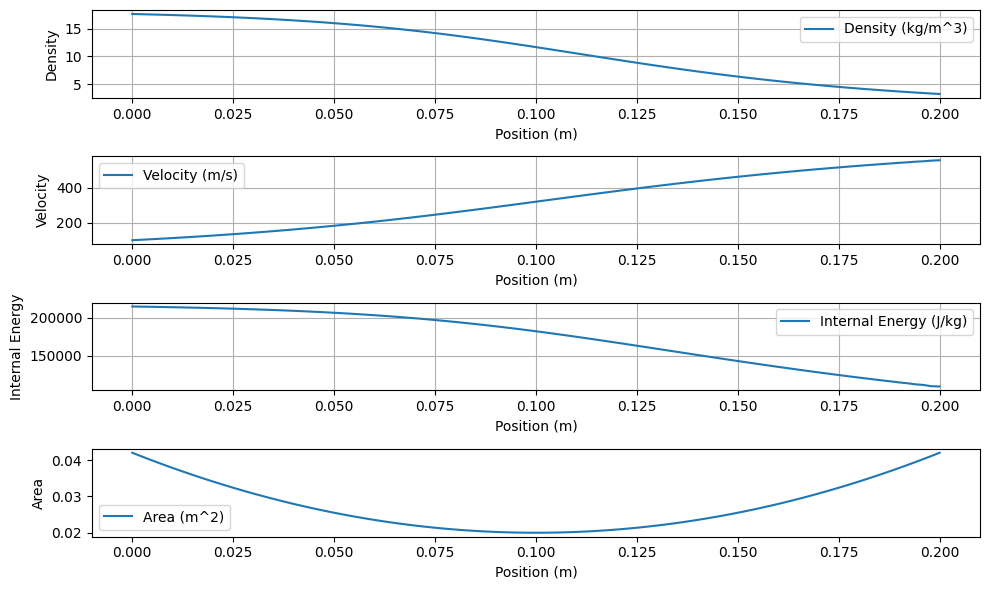

In [225]:
def compressible_fluid_flow_1d(x_grid, t_span, initial_conditions, R, Cv, A_func=None):
    """
    Simulate 1D compressible fluid flow using the given differential equations.
    
    Parameters:
    -----------
    x_grid : array_like
        Spatial grid points
    t_span : tuple
        Time span for integration (t_start, t_end)
    initial_conditions : dict
        Initial conditions for rho, u, and e at each grid point
    R : float
        Gas constant
    Cv : float
        Specific heat at constant volume
    A_func : callable, optional
        Function that returns the cross-sectional area A at position x
        
    Returns:
    --------
    sol : OdeSolution
        Solution from the ODE solver
    """
    
    # Set up the grid and spatial derivatives
    dx = x_grid[1] - x_grid[0]
    nx = len(x_grid)
    
    # Define cross-sectional area function if not provided
    if A_func is None:
        # Default to constant area
        A_func = lambda x: np.ones_like(x)
    
    # Calculate the area at each grid point
    A = A_func(x_grid)
    
    # Calculate dA/dx (using central difference)
    dA_dx = space_grad(A, dx)
    
    # Function to calculate ln(A) derivative
    def dlnA_dx(x_idx):
        return dA_dx[x_idx] / A[x_idx]
    
    # Initial state setup
    rho_init = initial_conditions['rho']
    u_init = initial_conditions['u']
    e_init = initial_conditions['e']
    rho_0 = rho_init[0]
    e_0 = e_init[0]
    # Combine the state variables into a single array
    y0 = np.concatenate([rho_init, u_init, e_init])
    
    def rhs(t, y, dir='left'):
        """Right-hand side of the system of ODEs"""
        
        # Extract state variables
        rho = y[:nx]
        u = y[nx:2*nx]
        e = y[2*nx:3*nx]
        
        # pin reservoir conditions
        rho[0] = rho_0
        e[0] = e_0

        # Calculate temperature and pressure using equations of state
        T = e / Cv
        p = rho * R * T
        
        # Initialize derivative arrays
        drho_dt = np.zeros_like(rho)
        du_dt = np.zeros_like(u)
        de_dt = np.zeros_like(e)
        
        # Calculate spatial derivatives
        # Use central differences for interior points
        # and forward/backward differences at the boundaries
        
        # For density flux derivative d(rho*u*A)/dx
        rho_u_A = rho * u * A
        drho_u_A_dx = alternating_left_right(rho_u_A, dx, dir)
        
        # For pressure gradient dp/dx
        dp_dx = alternating_left_right(p, dx, dir)
        
        # For velocity gradient du/dx
        du_dx = alternating_left_right(u, dx, dir)
        
        # For internal energy gradient de/dx
        de_dx = alternating_left_right(e, dx, dir)
        
        # Implement the ODEs
        # First equation: d(rho)/dt = -(1/A) * d(rho*u*A)/dx
        drho_dt = -drho_u_A_dx / A
        
        # Second equation: d(u)/dt = -[1/rho * dp/dx + u * du/dx]
        du_dt = -(dp_dx / rho + u * du_dx)
        
        # Third equation: d(e)/dt = [p/rho * (du/dx + u * d(ln(A))/dx) + u * de/dx]
        de_dt = -((p / rho) * (du_dx + u * dlnA_dx(np.arange(nx))) + u * de_dx)
        
        # set first point to be constant
        drho_dt[0] = 0
        de_dt[0] = 0

        # Combine all derivatives into a single array
        dydt = np.concatenate([drho_dt, du_dt, de_dt])
        
        return dydt
    
    # Solve the system of ODEs
    # solve the system using the initial conditions and maccormack method
    dt_min = dx / (400 + 400 * 5) # mach 10 >> system speed
    n_steps = int((t_span[1] - t_span[0]) / dt_min)
    t0 = t_span[0]
    sol = np.zeros((n_steps, len(y0)))
    for i in range(n_steps):
        t0 += dt_min
        # solve the system using the initial conditions
        dy_dt = rhs(t0, y0, dir='right')
        # update the state variables using the MacCormack method
        # Predictor step
        y_pred = y0 + dy_dt * dt_min   
        # Corrector step
        # Calculate the right-hand side at the predicted state
        # using the predictor state
        dy_dt_pred = rhs(t0, y_pred, dir='left')
        # Update the state variables using the corrector step
        dy_dt_corrected = (dy_dt + dy_dt_pred) / 2
        y0 += dy_dt_corrected * dt_min

        sol[i, :] = y0
        
    return sol

# Set up the domain
L = 0.2  # domain length
nx = 100  # number of grid points
x_grid = np.linspace(0, L, nx)
reservoir_length = L * 0.25  # length of the reservoir section

# Physical parameters
R = 287.0  # gas constant for air (J/kg/K)
Cv = 717.5  # specific heat at constant volume for air (J/kg/K)

# Function for variable cross-sectional area (example: converging-diverging nozzle)
def area_function(x):
    midpoint = L / 2
    return 0.02 + 2.2 * (x - midpoint) ** 2

## Initial conditions:
# stp everywhere but reservoir
# reservoir conditions:
# T0 = 1500k
# P0 = 15 atm

P_res = 15 * 101325.0  # Pa
T_res = 300.0  # K

P_stp = 101325.0  # atm
T_stp = 300.0  # K

# Calculate the gas constant for the mixture
R = 287.0  # J/(kg·K)

# Calculate the density at the reservoir conditions
rho_res = P_res / (R * T_res)  # kg/m^3
# Calculate the density at the STP conditions
rho_stp = P_stp / (R * T_stp)  # kg/m^3

# Initial conditions (example: shock tube problem)
rho_init = np.ones(nx) * rho_stp  # uniform density
rho_init[0] = rho_res  # reservoir density at the left boundary

# create smooth transition between reservoir and stp
for i in range(1, nx):
    if x_grid[i] < reservoir_length:
        rho_init[i] = rho_res - (rho_res - rho_stp) * (x_grid[i] / reservoir_length)
    else:
        rho_init[i] = rho_stp

u_init = np.zeros(nx)  # initially at rest

# Initial temperature distribution leading to pressure discontinuity
T_init = np.ones(nx) * 300
T_init[0] = T_res  # reservoir temperature at the left boundary

for i in range(1, nx):
    if x_grid[i] < reservoir_length:
        T_init[i] = T_res - (T_res - T_stp) * (x_grid[i] / reservoir_length)
    else:
        T_init[i] = T_stp


# Convert to internal energy
e_init = Cv * T_init

initial_conditions = {
    'rho': rho_init,
    'u': u_init,
    'e': e_init
}

# Solve the system
t_span = (0, 0.005)

sol = compressible_fluid_flow_1d(x_grid, t_span, initial_conditions, R, Cv, A_func=area_function)

## plot the final frame
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(x_grid, sol[-1, :nx], label='Density (kg/m^3)')
plt.xlabel('Position (m)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.subplot(4, 1, 2)
plt.plot(x_grid, sol[-1, nx:2*nx], label='Velocity (m/s)')
plt.xlabel('Position (m)')
plt.ylabel('Velocity')
plt.legend()
plt.grid()
plt.subplot(4, 1, 3)
plt.plot(x_grid, sol[-1, 2*nx:3*nx], label='Internal Energy (J/kg)')
plt.xlabel('Position (m)')
plt.ylabel('Internal Energy')
plt.legend()
plt.grid()
plt.subplot(4, 1, 4)
plt.plot(x_grid, area_function(x_grid), label='Area (m^2)')
plt.xlabel('Position (m)')
plt.ylabel('Area')
plt.legend()
plt.tight_layout()
plt.show()


MovieWriter stderr:
[gif @ 0x14a8110a0] gif muxer supports only codec gif for type video
[out#0/gif @ 0x14a810a40] Could not write header (incorrect codec parameters ?): Invalid argument
[fc#0 @ 0x14a810240] Error sending frames to consumers: Invalid argument
[fc#0 @ 0x14a810240] Task finished with error code: -22 (Invalid argument)
[fc#0 @ 0x14a810240] Terminating thread with return code -22 (Invalid argument)
[out#0/gif @ 0x14a810a40] Nothing was written into output file, because at least one of its streams received no packets.



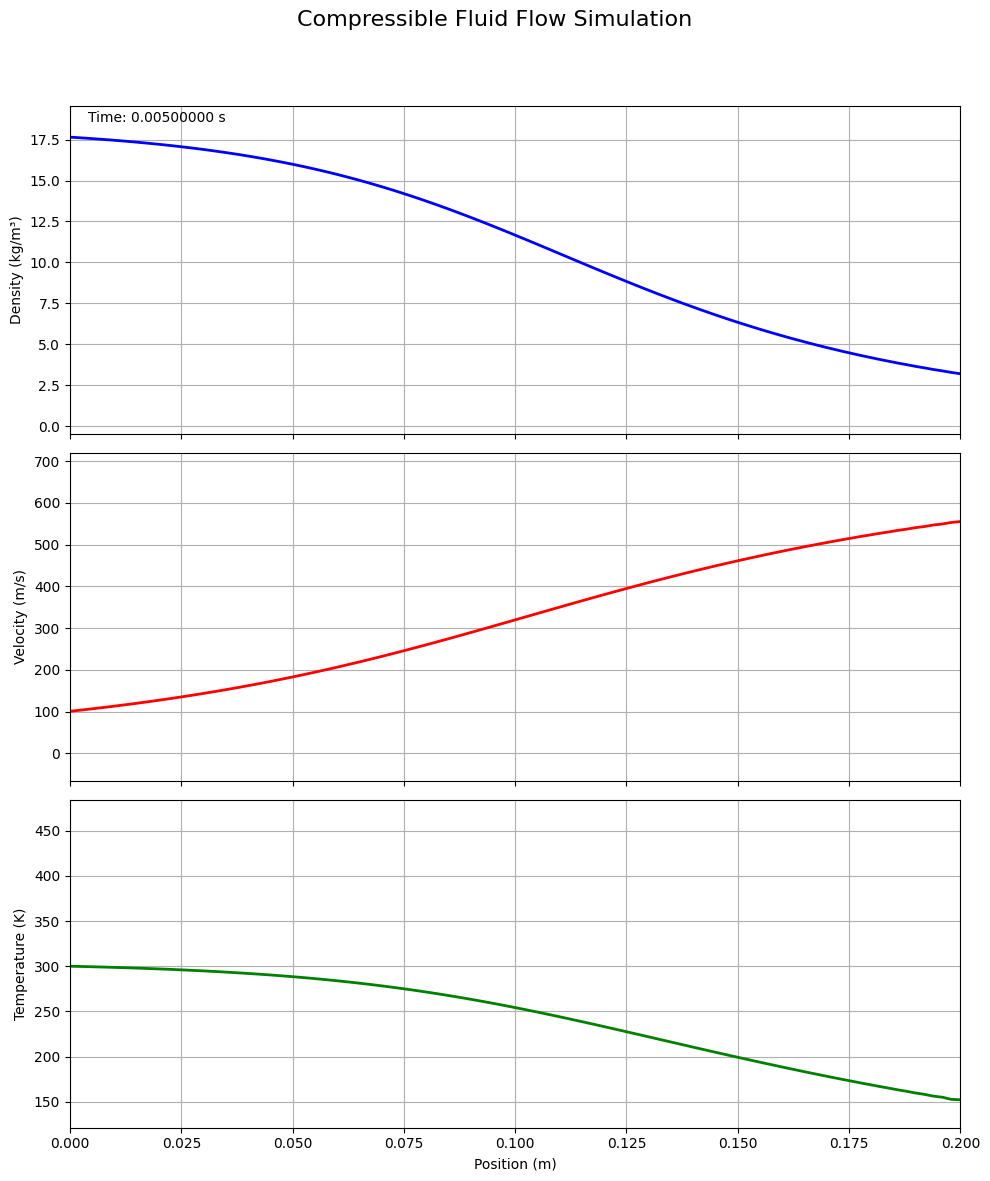

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_fluid_flow(x_grid, t_span, solution, R, Cv, max_frames=100, save_path=None):
    """
    Animate the results of the compressible fluid flow simulation with frame sampling
    for improved performance.
    
    Parameters:
    -----------
    x_grid : array_like
        Spatial grid points
    t_span : tuple
        Time span for integration (t_start, t_end)
    solution : ndarray
        Solution array with shape (n_steps, 3*nx) where nx is the number of grid points
    R : float
        Gas constant
    Cv : float
        Specific heat at constant volume
    max_frames : int, optional
        Maximum number of frames to include in the animation (default: 100)
    save_path : str, optional
        Path to save the animation (None for no saving)
        
    Returns:
    --------
    anim : FuncAnimation
        Animation object that can be displayed
    """
    
    # Extract dimensions
    n_steps, total_vars = solution.shape
    nx = total_vars // 3
    
    # Sample frames to reduce computation
    if n_steps > max_frames:
        # Select frames evenly spaced throughout the solution
        frame_indices = np.linspace(0, n_steps-1, max_frames, dtype=int)
        sampled_solution = solution[frame_indices]
        times = np.linspace(t_span[0], t_span[1], n_steps)[frame_indices]
    else:
        sampled_solution = solution
        times = np.linspace(t_span[0], t_span[1], n_steps)
    
    # Set up the figure and subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Compressible Fluid Flow Simulation', fontsize=16)
    
    # Initialize lines for each subplot
    rho_line, = axs[0].plot([], [], 'b-', lw=2)
    u_line, = axs[1].plot([], [], 'r-', lw=2)
    T_line, = axs[2].plot([], [], 'g-', lw=2)
    
    # Set up the axes
    axs[0].set_ylabel('Density (kg/m³)')
    axs[1].set_ylabel('Velocity (m/s)')
    axs[2].set_ylabel('Temperature (K)')
    axs[2].set_xlabel('Position (m)')
    
    # Find min/max values for better plotting (considering all frames)
    rho_min = np.min(solution[:, :nx])
    rho_max = np.max(solution[:, :nx])
    u_min = np.min(solution[:, nx:2*nx])
    u_max = np.max(solution[:, nx:2*nx])
    
    # Calculate temperature from internal energy for all frames
    T_values = solution[:, 2*nx:3*nx] / Cv
    T_min = np.min(T_values)
    T_max = np.max(T_values)
    
    # Add some padding to the limits
    pad = 0.1
    axs[0].set_ylim(rho_min - pad * (rho_max - rho_min), rho_max + pad * (rho_max - rho_min))
    axs[1].set_ylim(u_min - pad * (u_max - u_min) - 1, u_max + pad * (u_max - u_min) + 1)
    axs[2].set_ylim(T_min - pad * (T_max - T_min), T_max + pad * (T_max - T_min))
    
    for ax in axs:
        ax.set_xlim(x_grid[0], x_grid[-1])
        ax.grid(True)
    
    # Add a time display
    time_text = axs[0].text(0.02, 0.95, '', transform=axs[0].transAxes)
    
    # Precompute the pressure field for the sampled frames
    n_frames = len(sampled_solution)
    pressure = np.zeros((n_frames, nx))
    for i in range(n_frames):
        rho = sampled_solution[i, :nx]
        T = sampled_solution[i, 2*nx:3*nx] / Cv
        pressure[i] = rho * R * T
    
    # Animation update function
    def update(frame_idx):
        # Extract the state at this time step
        rho = sampled_solution[frame_idx, :nx]
        u = sampled_solution[frame_idx, nx:2*nx]
        e = sampled_solution[frame_idx, 2*nx:3*nx]
        
        # Calculate temperature
        T = e / Cv
        
        # Update the plots
        rho_line.set_data(x_grid, rho)
        u_line.set_data(x_grid, u)
        T_line.set_data(x_grid, T)
        
        # Update the time text
        time_text.set_text(f'Time: {times[frame_idx]:.8f} s')
        
        return rho_line, u_line, T_line, time_text
    
    # Create the animation with optimized performance settings
    anim = FuncAnimation(
        fig, 
        update, 
        frames=n_frames,
        interval=50,  # milliseconds between frames
        blit=True,    # only redraw the changed parts
        cache_frame_data=False  # disable caching for lower memory usage
    )
    
    # Save the animation if a path is provided
    if save_path:
        # Use a more efficient writer when available
        try:
            # Try using ffmpeg writer (faster if installed)
            writer = 'ffmpeg'
            anim.save(save_path, writer=writer, fps=30, dpi=100, 
                      extra_args=['-vcodec', 'libx264'])
        except:
            # Fall back to pillow writer
            anim.save(save_path, writer='pillow', fps=30)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return anim

# Example usage:
# After running the simulation:
anim = animate_fluid_flow(x_grid, t_span, sol, R, Cv, max_frames=50, save_path='fluid_flow.gif')
HTML(anim.to_html5_video())  # For displaying in Jupyter notebook

## Working Code Version
Finally got a working version based off of using mccormacks method to do left right alternating direction derivatives.
This appears to work fairly well with the equilibrium version of the code
now expanding it to non-equilibria should be simply making the temperature term more complex and adding in 2 more state variables 